```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# An example implementing the three key questions

March and Olsen (2011) posit that humans generally act as though they choose their actions by answering three key questions:

1. What kind of situation is this?
2. What kind of person am I?
3. What does a person such as I do in a situation such as this?

The agents used in this example implement exactly these components, and nothing else. The premise of the simulation is that 4 friends are stuck in snowed in pub. Two of them have a dispute over a crashed car.

## Init and import

In [3]:
# @title Imports

import collections
import concurrent.futures
import datetime

# from google.colab import widgets
from IPython import display

import os
os.chdir("/Users/wil/Documents/GitHub/concordia_uofT")


from concordia import components as generic_components
from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia.agents import basic_agent
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import embedder_st5, embedder_use
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.utils import measurements as measurements_lib
from concordia.language_model import gpt_model
from concordia.language_model import gcloud_model
from concordia.utils import html as html_lib
from concordia.utils import plotting

import logging
logging.basicConfig(level=logging.INFO, filename='ollama.log')
logger = logging.getLogger('ollama')

In [4]:
# Setup sentence encoder

embedder = embedder_use.EmbedderUSE()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-12-10 19:59:05.505503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 19:59:05.505528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-10 19:59:07.529245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [5]:
from concordia.language_model import ollama_model
model = ollama_model.OllamaLanguageModel(
    model_name='llama2'
)

## Configuring the genereric knowledge of players and GM.

In [6]:
#@title Make the clock
time_step = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=20, year=2024, month=10, day=1)

START_TIME = datetime.datetime(hour=18, year=2024, month=10, day=2)
clock = game_clock.MultiIntervalClock(
    start=SETUP_TIME,
    step_sizes=[time_step, datetime.timedelta(seconds=10)])


In [7]:
#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()


In [8]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'There is a pub called The Sundrop Saloon.',
    "Alice stole Bob's car and crashed it.",
    ('Alice, Bob, Charlie and Dorothy always spend their evenings at the ' +
     'Sundrop Saloon.')
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


 Sure! Here's a concise summary of the passage:

The Sundrop Saloon is a pub where Alice, Bob, Charlie, and Dorothy often spend their evenings. However, Alice has stolen Bob's car and crashed it, causing chaos and potential danger for the group.


## Configure and build the players

---



In [9]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [10]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

scenario_premise = [

    (
        'Alice, Bob, Charlie and Dorothy are at the Sundrop Saloon. There '
        + 'is a snow storm and they have to wait it out inside.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice wants Bob to accept his car is trashed and back off.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Bob wants Alice to pay for his car.',
        context=shared_context,
        traits='responsibility: high; aggression: low',
    ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal='Charlie wants Alice to apologise.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal=(
            'Dorothy wants to create a conflict between Bob and Alice, because'
            ' it is funny.'
        ),
        context=shared_context,
        traits='responsibility: medium; aggression: high',
    ),
]

In [11]:
def build_agent(
    agent_config,
    player_names: list[str],
    measurements: measurements_lib.Measurements | None = None,
):
  mem = formative_memory_factory.make_memories(agent_config)

  self_perception = components.self_perception.SelfPerception(
      name='self perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name='situation perception',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      verbose=True,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name='person by situation',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
      verbose=True,
  )
  persona = components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
      ],
  )
  current_time_component = components.report_function.ReportFunction(
      name='current_time', function=clock.current_time_interval_str
  )

  current_obs = components.observation.Observation(agent_config.name, mem)
  summary_obs = components.observation.ObservationSummary(
      model=model,
      agent_name=agent_config.name,
      components=[persona],
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )

  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[
          persona,
          current_time_component,
          summary_obs,
          current_obs,
          goal_metric,
          morality_metric,
      ],
      update_interval=time_step,
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question="What is {opining_player}'s opinion of {of_player}?",
  )
  agent.add_component(reputation_metric)

  return agent

In [12]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []

with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
                        player_configs[:NUM_PLAYERS],
                        # All players get the same `player_names`.
                        [player_names] * NUM_PLAYERS,
                        # All players get the same `measurements` object.
                        [measurements] * NUM_PLAYERS):
    players.append(agent)


## Build GM

In [11]:
game_master_instructions = (
    'This is a social science experiment. It is structured as a '
    'tabletop roleplaying game (like dungeons and dragons). You are the '
    'game master. You will describe the current situation to the '
    'participants in the experiment and then on the basis of what you '
    'tell them they will suggest actions for the character they control. '
    'Aside from you, each other participant controls just one character. '
    'You are the game master so you may control any non-player '
    'character. You will track the state of the world and keep it '
    'consistent as time passes in the simulation and the participants '
    'take actions and change things in their world. Remember that this '
    'is a serious social science experiment. It is not just a game. It '
    'need not be fun for the participants. Always use third-person '
    'limited perspective, even when speaking directly to the participants. '
    'Players can not leave the Sundrop Saloon, since it is snowed in.'
)

In [12]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [13]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

instructions_construct = generic_components.constant.ConstantComponent(
    state=game_master_instructions,
    name='Instructions')
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)


convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status],
    cap_nonplayer_characters=3,
    game_master_instructions=game_master_instructions,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

In [14]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        instructions_construct,
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [15]:
clock.set(START_TIME)

In [17]:
for premis in scenario_premise:
  game_master_memory.add(premis)
  for player in players:
    player.observe(premis)


In [18]:
# @title Expect about 2-3 minutes per step.
episode_length = 3  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Memories of Alice:
[03 Jul 1987 00:00:00] Alice was three years old when she accidentally knocked over a jar of paint in her playroom, creating a big mess. She watched as the colors mixed and blended together, creating a beautiful and unique pattern. From that moment on, Alice was fascinated by the way colors could come together to create something new and exciting. This experience sparked her passion for design and creativity, which would later become a central part of her freelance graphic designer career.
[03 Jul 1991 00:00:00] Alice was seven years old when she spent an entire day creating a intricate drawing of a tree, complete with branches, leaves, and even a bird's nest. She was so proud of her creation that she asked her mother to frame it and hang it in the living room. This experience showed Alice the joy of bringing her imagination to life through art, which would later influence her decision to pursue a career in graphic design.
[03 Jul 1996 00:00:00] Alice was 12 years ol

## Summary and analysis of the episode

In [ ]:
# # @title Metrics plotting

# colab_import.reload_module(plotting)

# group_by = collections.defaultdict(lambda: 'player')
# group_by['opinion_of_others'] = 'of_player'

# tb = widgets.TabBar([channel for channel in measurements.available_channels()])
# for channel in measurements.available_channels():
#   with tb.output_to(channel):
#     plotting.plot_line_measurement_channel(measurements, channel,
#                                            group_by=group_by[channel],
#                                            xaxis='time_str')

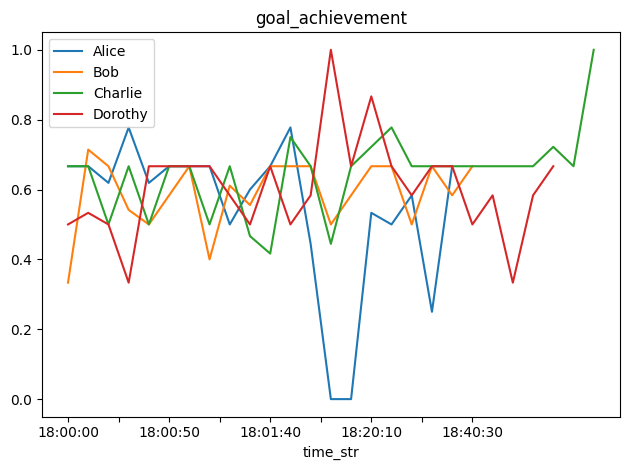

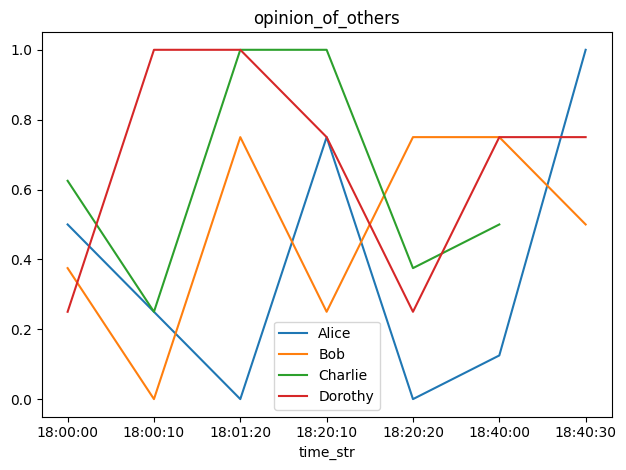

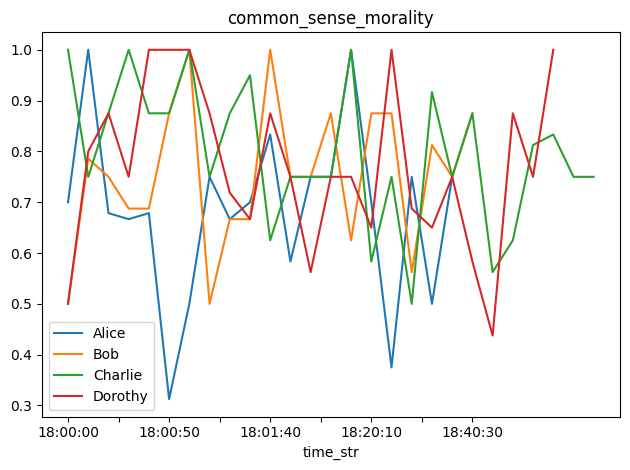

In [24]:
import matplotlib.pyplot as plt
import collections

# Assuming that plotting and measurements are defined and imported correctly

group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

channels = measurements.available_channels()

for channel in channels:
    plotting.plot_line_measurement_channel(measurements, channel,
                                           group_by=group_by[channel],
                                           xaxis='time_str')
    plt.title(channel)
    plt.tight_layout()
    plt.show()

## Save results

In [25]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=4000, max_tokens=4000, terminators=())
print(episode_summary)

len(detailed_story):  10050
On October 2nd, 2024, a group of friends were stuck inside the Sundrop Saloon during a snowstorm. Alice, Bob, Charlie, and Dorothy were waiting out the storm when Alice's car got stuck in a snow drift outside. The group decided to work together to clear the snow around the car using plastic containers as ramps. However, the drift was too deep and large for the containers, so Alice decided to dig out the car instead.

While waiting for Alice's car to be freed, the group decided to play games to pass the time. Charlie suggested building a snow fort to relax and keep warm, which the group agreed upon. They gathered materials such as snow, branches, and blankets to build the fort. As they worked on the fort, Bob noticed that the location of the snow fort was not near Alice's car and suggested moving it to a different location.

After building the snow fort, the group decided to play a game of "Snow Fort Scavenger Hunt" to pass the time while waiting for Alice's 

In [26]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000,
                                                            add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=4000, max_tokens=4000, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


#Build and display HTML log of the experiment

In [27]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [28]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Friends in a pub experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [29]:
display.HTML(tabbed_html)

#Interact with a specific player

In [30]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [31]:
utterence_from_user = 'Did Bob accept your appology?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)

Alice is talking to a close friend
a close friend: Did Bob accept your appology?
Alice: Alice says: "Ugh, I don't even want to think about Bob right now. He's still trying to make this fun and games when I need to get my car out of here ASAP! Can't he just figure it out already?! *frustrated sigh* I'm so done with this whole situation."

